# Movie Recommendations using Collaborative Filtering
### - Dataset used: Group Lens 100K movie dataset

In [1]:
#Imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from scipy.optimize import fmin_cg

#CONSTANTS
"""Read data from files."""
DATAPATH = "/Users/debojitkaushik/collaborative-filtering/ml-100k/"
Y_cols  = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(DATAPATH + 'u.data', sep = '\t', encoding = 'latin-1', names = Y_cols).drop("timestamp", 1)

### - Preprocessing/Formatting
Create movies VS user matrix and ratings matrix. Create Y matrix and ratings matrix. Data is a dataframe with UserID|Movie_id|Rating format. Need to Vectorize this into a ratings matrix of MovieID vs UserID. Create the R matrix, which will have 1 if a user has rated or 0 if not.

In [2]:
nm, nu = len(data['item_id'].unique()), len(data['user_id'].unique())
nf = 10

# Initilize two matrices of size (nm, nu) and fill in the data.
# # **Slow method. Need to optimize this. Will look into Pandas methods more. 
Y, ratings  = np.zeros((nm, nu)), np.zeros((nm, nu))
for it, item in data.iterrows():
    ratings[item['item_id']-1][item['user_id']-1] = 1.0
    Y[item['item_id']-1][item['user_id']-1] = item['rating']
print("Y:" , Y.shape)
print("R:", ratings.shape)

#OPTIONAL DATA SOURCE:
# datafile = 'aux_data/ex8_movies.mat'
# mat = scipy.io.loadmat( datafile )
# Y = mat['Y']
# ratings = mat['R']

Y: (1682, 943)
R: (1682, 943)


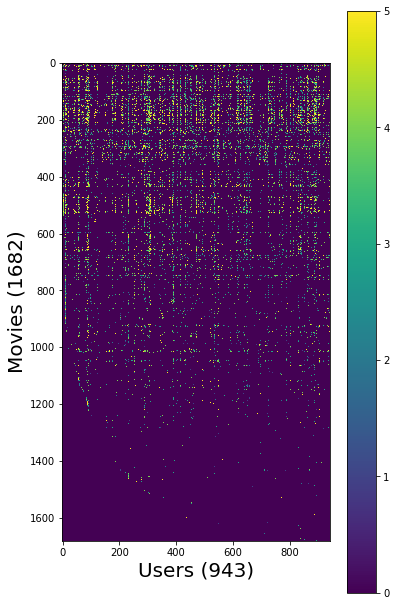

In [3]:
#Visualize the data matrix.
fig = plt.figure(figsize=(6,6*(nm/nu)))
dummy = plt.imshow(Y)
dummy = plt.colorbar()
dummy = plt.ylabel('Movies (%d)'%nm,fontsize=20)
dummy = plt.xlabel('Users (%d)'%nu,fontsize=20)
#We can see the sparseness of the matrix as it is dominated by 0 values.

### - Cost Function and Gradient definitions

In [4]:
#OPTIONAL: loading Theta and X matrices. 
# mat = scipy.io.loadmat("data/ex8_movieParams.mat")
# theta, X, nf = mat['Theta'], mat['X'], mat['num_features']

#Let's randomly initialize Theta and X matrices for starting points before we start learning.
X, Theta = np.random.rand(nm, nf), np.random.rand(nu, nf)
print("Shapes of Theta, X, Y, ratings:", [i.shape for i in [Theta, X, Y, ratings]])

Shapes of Theta, X, Y, ratings: [(943, 10), (1682, 10), (1682, 943), (1682, 943)]


In [5]:
'''Method to flatten theta and X matrices into one vector'''
def flatten_mat(X, Theta):
    try:
        return np.concatenate((X.flatten(), Theta.flatten()))
    except Exception as e:
        print(e)
        
'''Method to extract X and theta from the flattened matrix and reshape.'''
def unflatten(flattened_mat, mynu, mynm, mynf):
    #X dimensions: nm*nf, theta dimensions: nu*nf
    new_X = flattened_mat[:int(nm*nf)].reshape(mynm, mynf)
    new_theta = flattened_mat[int(nm*nf):].reshape(mynu, mynf)
    return new_X, new_theta

'''Compute cost function'''
def CFCost(params, myY, myR, mynu, mynm, mynf, myLambda = 0):
    '''
    args:
        params: X+Theta (flattened vector)
        myY: Movies VS Users matrix.
        nu, nm, nf: No of user, no of movies, no of features
    '''
    #Extract X and theta from params which is a merged vector.
    myX, myTheta = unflatten(params, mynu, mynm, mynf)
    
    #1/2∑((theta).T * X - Y)^2 + Regularization term
    term1 = myX.dot(myTheta.T)
    term1 = np.multiply(term1, myR)
    cost = 0.5 * np.sum(np.square(term1 - myY))
    
    #Regularization factors. Twice, for lambda and for X.
    #Regularizer: (λ/2) * (theta)^2 or (X)^2
    cost += (myLambda/2) * (np.sum(np.square(myTheta)))
    cost += (myLambda/2) * (np.sum(np.square(myX)))
    return cost

print(CFCost(flatten_mat(X, Theta), Y, ratings, nu, nm, nf))

'''Gradient function. f'. '''
def CFCostGrad(params, myR, myY, mynu, mynm, mynf, myLambda = 0):
    '''
    args:
        params: X+Theta (flattened vector)
        myY: Movies VS Users matrix with their ratings.
        myR: Ratings binary matrix 0/1.
        nu, nm, nf: No of user, no of movies, no of features
    '''
    #This is the partial derivative of the cost function with respect
    #to theta and X.
    #Unroll params into Theta and X and proceed with the derivative 
    #calculation.
    myX, myTheta = unflatten(params, mynu, mynm, mynf)
    term1 = myX.dot(myTheta.T)
    term1 = np.multiply(term1, myR)
    term1 = term1 - myY
    X_grad = term1.dot(myTheta)
    theta_grad = term1.T.dot(myX)

    #Regularization
    X_grad += (myLambda * myX)
    theta_grad += (myLambda * myTheta)
    return flatten_mat(X_grad, theta_grad)

141274.52978818992


In [6]:
def check_gradient(params, myR, myY, mynu, mynm, mynf, myLambda = 0):
    epsilon = 0.0001
    eps_vec = np.zeros(len(params))
    myX, myTheta = unflatten(params, mynu, mynm, mynf)
    grads = CFCostGrad(params, myR, myY, mynu, mynm, mynf, myLambda = 1.5)

    for _ in range(10):
        idx = np.random.randint(len(params))
        eps_vec[idx] = epsilon
        loss1 = CFCost(params-eps_vec, myY, myR, mynu, mynm, mynf, myLambda = 1.5)
        loss2 = CFCost(params+eps_vec, myY, myR, mynu, mynm, mynf, myLambda = 1.5)
        
        mygrad = (loss2 - loss1) / (2*epsilon)
        eps_vec[idx] = 0
        print(mygrad, grads[idx], mygrad - grads[idx])


In [7]:
print("Checking gradient function for lambda = 0:")
check_gradient(flatten_mat(X, Theta), ratings, Y, nu, nm, nf, myLambda = 0)
print("\nChecking gradient function for lambda = 1.5:")
check_gradient(flatten_mat(X, Theta), ratings, Y, nu, nm, nf, myLambda = 1.5)

Checking gradient function for lambda = 0:
-14.49467075872235 -14.494670645330357 -1.1339199268434186e-07
-23.922144901007414 -23.92214489697681 -4.0306034065906715e-09
-112.72813440882601 -112.72813467603315 2.6720714174643945e-07
5.332984874257818 5.332984838753424 3.550439409139017e-08
-170.79007608117536 -170.7900760135203 -6.765506554984313e-08
-10.098216880578548 -10.09821678137577 -9.920277754815743e-08
-113.9346907439176 -113.93469061774563 -1.2617196887276805e-07
-75.55213654995896 -75.55213611206472 -4.378942435323552e-07
-6.968218076508492 -6.968218405862184 3.2935369187470087e-07
-26.50699156220071 -26.50699170508196 1.4288124816630443e-07

Checking gradient function for lambda = 1.5:
1.815992727642879 1.815992773635306 -4.5992427200047814e-08
0.4484293458517641 0.4484294196965988 -7.38448346915277e-08
1.303371973335743 1.3033721937581269 -2.2042238390085345e-07
-37.57347629289143 -37.57347644252321 1.4963178074367534e-07
4.65432443888858 4.654324359074057 7.981452299077318

### - Learn parameters
Add own ratings to the data to be trained on and perform minimzation/gradient descent on params(Theta+X)

In [8]:
"""Learn parameters for recommendation"""
#Add a vector for my own recommendations. 
my_ratings = np.zeros([nm,1])
my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

#Current nm, nu, nf are:
print("Old nm, nu, nf", nm, nu, nf)

#Add my ratings vector to the matrices. 
Y = np.hstack((Y, my_ratings))
myR = my_ratings > 0
ratings = np.hstack((ratings, myR.astype(int)))
print(Y.shape, ratings.shape)

Old nm, nu, nf 1682 943 10
(1682, 944) (1682, 944)


In [9]:
nm, nu = Y.shape
X, Theta = np.random.rand(nm, nf), np.random.rand(nu, nf)
my_flat_mat = flatten_mat(X, Theta)
print(my_flat_mat.shape)

(26260,)


In [10]:
#Call minimizer.
mylambda = 10.
res = fmin_cg(CFCost, x0 = my_flat_mat, \
              fprime = CFCostGrad, args = (ratings, Y, nu, nm, nf, mylambda), \
              maxiter=50, disp = True, full_output = True)


         Current function value: 3603326.053520
         Iterations: 0
         Function evaluations: 88
         Gradient evaluations: 76


In [11]:
print(nu, nm, nf)
new_X, new_theta = unflatten(res[0], nu, nm, nf)
pred_mat = new_X.dot(new_theta.T)

def normalizeRatings(myY, myR):
    # The mean is only counting movies that were rated
    Ymean = np.sum(myY,axis=1)/np.sum(myR,axis=1)
    Ymean = Ymean.reshape((Ymean.shape[0],1))
    
    return myY-Ymean, Ymean 

Ynorm, Ymean = normalizeRatings(Y, ratings)
my_pred = pred_mat[:,-1] + Ymean.flatten()

944 1682 10


In [13]:
#Read movie list. 
movies = []
with open("./aux_data/movie_ids.txt") as f:
    for item in f.read().split("\n"):
        movies.append(" ".join(item.split(" ")[1:]))

#Reverse sort my predictions and get the indexes. Then, get top 10 movies with those indexes.
pred_idxs_sorted = np.argsort(my_pred)
pred_idxs_sorted[:] = pred_idxs_sorted[::-1]


print("\033[1;34mTOP RECOMMENDATIONS FOR YOU:\033[1;m")
for i in range(10):
    print('\033[1;33mPredicting rating for movie\033[1;m', \
          str(my_pred[pred_idxs_sorted[i]])[:4],movies[pred_idxs_sorted[i]])

my_ratings = my_ratings.flatten()
print("\n\033[1;34mORIGINAL RATINGS BY YOU:\033[1;m")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('\033[1;33mRated for movie\033[1;m', my_ratings[i], movies[i])

TOP RECOMMENDATIONS FOR YOU:
Predicting rating for movie 7.69 Someone Else's America (1995)
Predicting rating for movie 7.15 Wrong Trousers, The (1993)
Predicting rating for movie 7.03 Santa with Muscles (1996)
Predicting rating for movie 6.96 African Queen, The (1951)
Predicting rating for movie 6.94 Close Shave, A (1995)
Predicting rating for movie 6.93 M (1931)
Predicting rating for movie 6.90 Three Colors: Red (1994)
Predicting rating for movie 6.89 Forbidden Planet (1956)
Predicting rating for movie 6.81 Pather Panchali (1955)
Predicting rating for movie 6.81 Brazil (1985)

ORIGINAL RATINGS BY YOU:
Rated for movie 4.0 Toy Story (1995)
Rated for movie 3.0 Twelve Monkeys (1995)
Rated for movie 5.0 Usual Suspects, The (1995)
Rated for movie 4.0 Outbreak (1995)
Rated for movie 5.0 Shawshank Redemption, The (1994)
Rated for movie 3.0 While You Were Sleeping (1995)
Rated for movie 5.0 Forrest Gump (1994)
Rated for movie 2.0 Silence of the Lambs, The (1991)
Rated for movie 4.0 Alien (197